In [1]:
# Imports
import random
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML

import model
from keijzer_exogan import *

# initialize random seeds
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab
# Initialize default seaborn layout
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
sns.set(style='ticks')


"""
Local variables
"""
workers = 0 # Number of workers for dataloader, 0 when to_vram is enabled
batch_size = 1 # using one image ofcourse
image_size = 32
nz = 100 # size of latent vector
n_iters = 25*10**3 # number of iterations to do for inpainting
torch.backends.cudnn.benchmark=True # Uses udnn auto-tuner to find the best algorithm to use for your hardware, speeds up training by almost 50%

lr = 1e-1
lamb1 = 1e3 #1e4
lamb2 = 1 # 1 , total_loss = lamb1*loss_context + lamb2*loss_perceptual

lr_G = 2e-4
beta1 = 0.5 # Beta1 hyperparam for Adam optimizers
selected_gpus = [3] # Number of GPUs available. Use 0 for CPU mode.

In [2]:
path = '/datb/16011015/ExoGAN_data/selection//' #notice how you dont put the last folder in here...

images = np.load(path+'last_chunks_25_percent_images_v3.npy').astype('float32')

len(images)

1250000

In [3]:
print('Batch size: ', batch_size)


# Number of training epochs

# Learning rate for optimizers
ngpu = len(selected_gpus)
print('Number of GPUs used: ', ngpu)


"""
Load data and prepare DataLoader
"""
shuffle = True

if shuffle:
    np.random.shuffle(images) # shuffles the images

images = images[:25] # 1200 should take ~ 1 hour
#images = images[:int(len(images)*0.005)]
print('Number of images: ', len(images))

Batch size:  1
Number of GPUs used:  1
Number of images:  25


In [4]:
dataset = numpy_dataset(data=images, to_vram=True) # to_vram pins it to all GPU's
#dataset = numpy_dataset(data=images, to_vram=True, transform=transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])) # to_vram pins it to all GPU's

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, pin_memory=False)

"""
Load and setup models
"""
# Initialize cuda
device = torch.device("cuda:"+str(selected_gpus[0]) if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Load models, set to evaluation mode since training is not needed (this also allows batchsize 1 to work with batchnorm2d layers)
netG = model.Generator(ngpu).eval().to(device)
netD = model.Discriminator(ngpu).eval().to(device)

# Apply weights
print('Loading weights...')
try:
    # Load saved weights
    netG.load_state_dict(torch.load('gan_data//weights//netG_state_dict0_v3_test', map_location=device)) #net.module..load_... for parallel model , net.load_... for single gpu model
    netD.load_state_dict(torch.load('gan_data//weights//netD_state_dict0_v3_test', map_location=device))
except:
    print('Could not load saved weights.')
    sys.exit()





"""
Define input training stuff (fancy this up)
"""
G = netG
D = netD
z = torch.randn(1, nz, 1, 1, requires_grad=True, device=device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    G = nn.DataParallel(G, device_ids=selected_gpus, output_device=device)
    D = nn.DataParallel(D, device_ids=selected_gpus, output_device=device)
    #z = nn.DataParallel(z, device_ids=selected_gpus, output_device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999)) # should be sgd
optimizerG = optim.Adam(netG.parameters(), lr=lr_G, betas=(beta1, 0.999))

print('done')

Loading weights...
done


# Show generated images

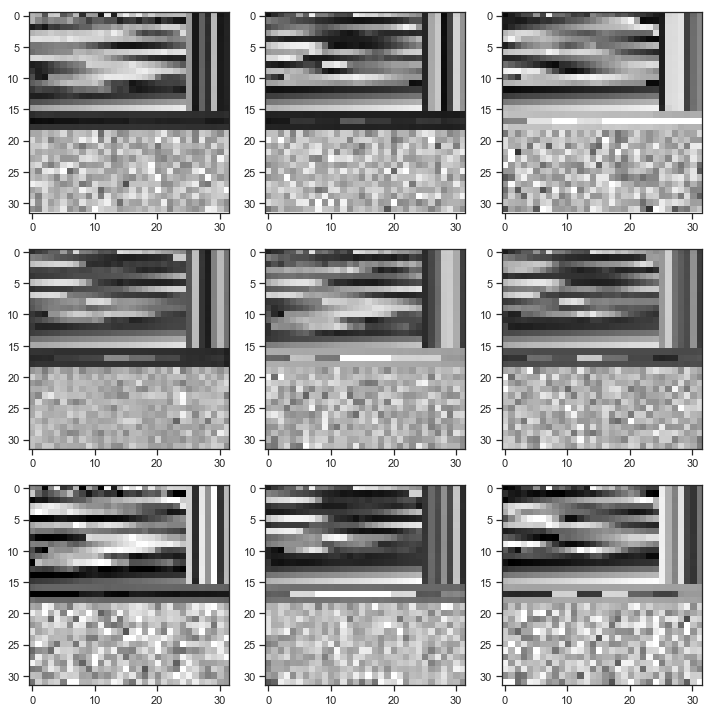

In [5]:
from sklearn.preprocessing import MinMaxScaler

z_tests = [torch.randn(1, nz, 1, 1, device=device) for _ in range(9)]

plt.figure(figsize=(10,10))
for i in range(9):
    img = G(z_tests[i]).detach().cpu()[0, 0, :, :]
    plt.subplot(3,3,i+1)
    #scaler = MinMaxScaler((0, 1.2))
    #img = scaler.fit_transform(img)
    plt.imshow(img, cmap='gray', vmin=-1.2, vmax=1.2)
    #plt.imshow(img, cmap='gray')

plt.tight_layout()

In [6]:
img.min(), img.max(), img.mean(), img.std()

(tensor(-1.3089), tensor(1.6892), tensor(0.2116), tensor(0.6228))

## Make sure Z is different for each image

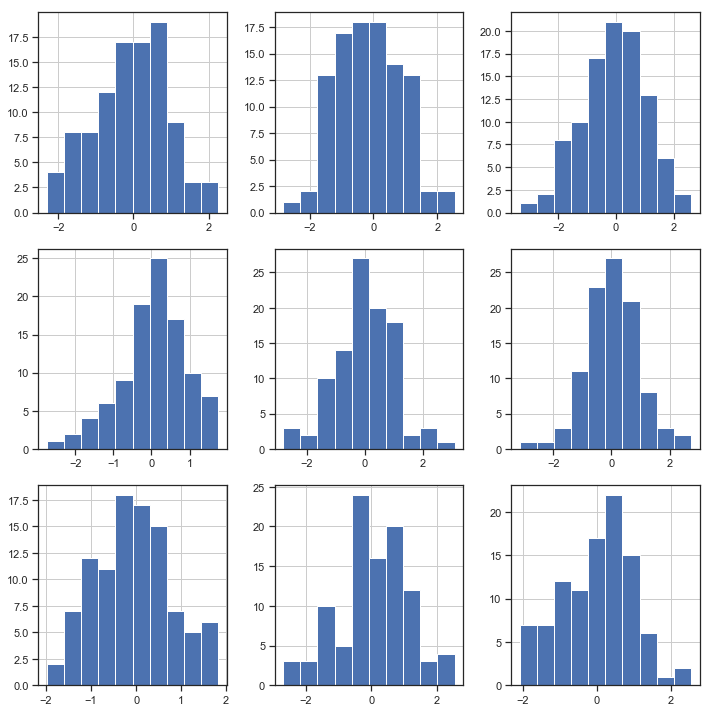

In [7]:
plt.figure(figsize=(10,10))
for i,z_t in enumerate(z_tests):
    z_t = z_t.detach().cpu().numpy()
    
    plt.subplot(3,3,i+1)
    
    plt.hist(z_t.flatten())
    plt.grid()
    
    plt.tight_layout()
    #print(z_t[0].flatten())

## Show first 9 selected images

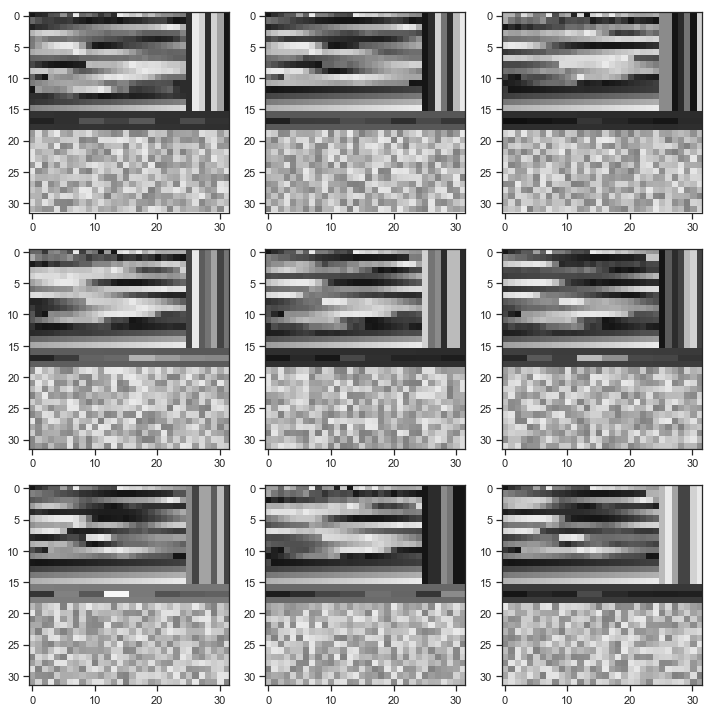

In [8]:
plt.figure(figsize=(10,10))
for i in range(9):
    try:
        img = images[i]
        plt.subplot(3,3,i+1)
        plt.imshow(img[0, :, :], cmap='gray', vmin=-1.2, vmax=1.2)
    except:
        pass

plt.tight_layout()

In [9]:
img.min(), img.max(), img.mean(), img.std()

(-1.0021654, 1.0, 0.14377047, 0.6042961)

# Visualizing the weights for debugging purposes

Layer: 0 	 n_weights: 512 	 std: 0.0543 	 mean: -0.0002
Layer: 1 	 n_weights: 16384 	 std: 0.2809 	 mean: 0.0052
Layer: 2 	 n_weights: 32768 	 std: 0.3949 	 mean: 0.0436
Layer: 3 	 n_weights: 131072 	 std: 0.4490 	 mean: 0.0514
Layer: 4 	 n_weights: 524288 	 std: 0.1621 	 mean: 0.0036
Layer: 5 	 n_weights: 256 	 std: 0.0113 	 mean: -0.0016


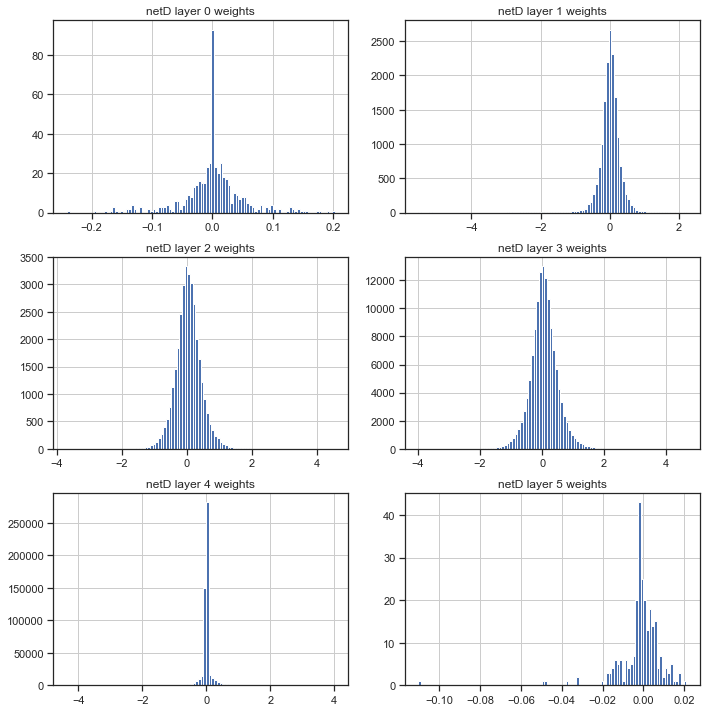

In [10]:
weights = [param.data.cpu().numpy().flatten() for param in netD.parameters()]

plt.figure(figsize=(10,10))
for i,layer_weights in enumerate(weights):
    print('Layer: %s \t n_weights: %s \t std: %.4f \t mean: %.4f' % (i, len(layer_weights), layer_weights.std(), layer_weights.mean()))
    plt.subplot(3,2,i+1)
    plt.title('netD layer %s weights' % i)
    plt.hist(layer_weights, bins=100)
    plt.grid()
    plt.tight_layout()

Layer: 0 	 n_weights: 409600 	 std: 0.0736 	 mean: -0.0001
Layer: 1 	 n_weights: 524288 	 std: 0.1146 	 mean: -0.0092
Layer: 2 	 n_weights: 131072 	 std: 0.1135 	 mean: -0.0029
Layer: 3 	 n_weights: 32768 	 std: 0.0937 	 mean: -0.0049
Layer: 4 	 n_weights: 16384 	 std: 0.0772 	 mean: -0.0023
Layer: 5 	 n_weights: 512 	 std: 0.0361 	 mean: 0.0004


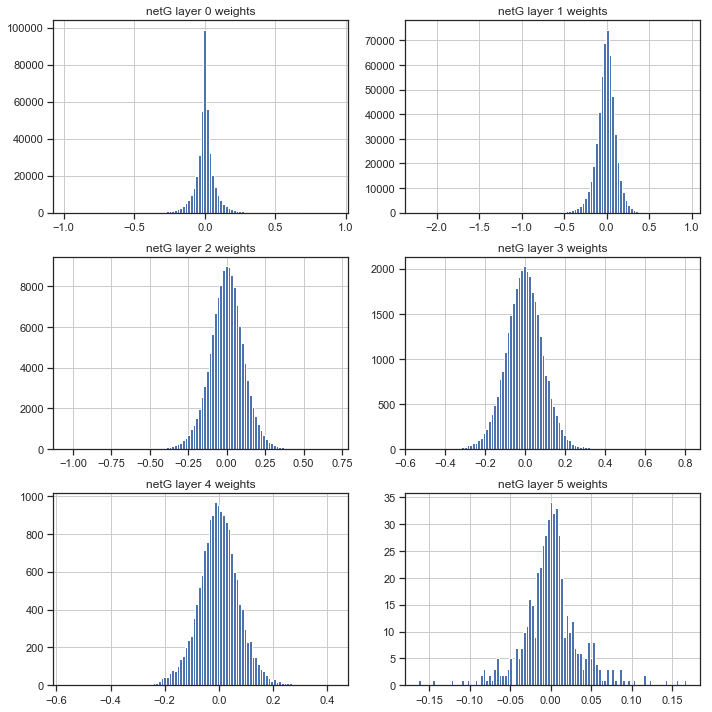

In [11]:
weights = [param.data.cpu().numpy().flatten() for param in netG.parameters()] # where param.data are the weights of the i-th layer

plt.figure(figsize=(10,10))
for i,layer_weights in enumerate(weights):
    print('Layer: %s \t n_weights: %s \t std: %.4f \t mean: %.4f' % (i, len(layer_weights), layer_weights.std(), layer_weights.mean()))
    plt.subplot(3,2,i+1)
    plt.title('netG layer %s weights' % i)
    plt.hist(layer_weights, bins=100)
    plt.grid()
    plt.tight_layout()

# Inpainting
The corrupted image $y$ is mapped to the closest $z$ in the latent representation space, this mapping is denoted as $\hat{z}$.
    
$\hat{z} = \operatorname{arg\,min}_z \{ \mathcal{L}_c(z |y, M) + \mathcal{L}_p (z) \}$

where

$\mathcal{L}_c(z |y, M) = || M \bigodot G(z) - M \bigodot y||_1 = || M \bigodot (G(z)-y) ||_1 $

with $\mathcal{L}_c$ being contextual loss and $M$ being a binary mask with the same size as $y$,

$\mathcal{L}_p (z) = \lambda \operatorname{log}(1-D(G(z)))$

with $\mathcal{L}_p$ being perceptual loss and $D$ being the discriminator.
  
Once $G(\hat{z})$ is generated, the final solution $\hat{x}$ is calculated as

$\hat{x} = \operatorname{arg\, min}_x ||\nabla x - \nabla G(\hat{z}) ||^2_2$  

(substitute $x_i = y_i$ for $M_i = 1$).

-----

$|| ... ||$ is done by `torch.norm()`.  
$... \bigodot ...$ is done by `torch.mul()`.  
-----
TODO: Implement $\hat{x} = \operatorname{arg\, min}_x ||\nabla x - \nabla G(\hat{z}) ||^2_2$    
Currently $\hat{x} = G(\hat{z}) \bigodot (1 -M)+y$

In [12]:
ind = pd.read_csv('wavelengths_and_indices.csv')  # where x is the wavelength

ind[(ind.x > 10) & (ind.x <= 14)]

,Unnamed: 0,x
129,129,13.900046
130,130,13.762421
131,131,13.626160
132,132,13.491247
133,133,13.357671
134,134,13.225416
135,135,13.094472
136,136,12.964823
137,137,12.836459
138,138,12.709365


In [13]:
def create_mask():
    
    mask = np.full([1,1,32,32], 1) # init array with 0.5's
    mask = torch.from_numpy(mask).to(device)
    
    #mask = torch.ones([1, 1, 32, 32]).to(device) # create mask with 1's in the shape of image
    
    #print("mask.shape", mask.shape)

    # use a random 'easy' mask
    mask[:, :, :16, 25:] = 0
    
    # The noise doesn't matter for conceptual loss
    mask[:, :, 19:, :] = 0
    
    """Weighted mask"""
    
    # Normalization factors
    mask[:, :, 16:19, :] = 3
    
    mask = mask.float() # make sure dtype is float, torch was complaining during inpainting that this is a double
    
    return mask

## Visualize the mask

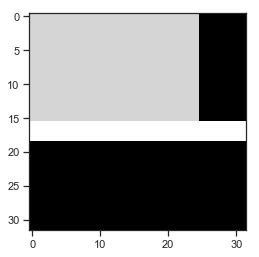

In [14]:
m = create_mask().cpu()[0, 0, :, :]
plt.imshow(m, cmap='gray', vmin=0, vmax=1.2) 

In [15]:
t = m.cpu().numpy().flatten()

for i in range(len(t)):
    if np.isnan(t[i]):
        print('nan')

In [16]:
# Lists to keep track of progress
real_images = []
masked_images= []
inpainted_images = []
final_inpainted_images = [] # last inpainted image for each input image
n_iteration = []

MSELoss = nn.MSELoss()
L1Loss = nn.L1Loss() # MAE
SmoothL1Loss = nn.SmoothL1Loss()

"""
Inpainting
"""
for i, data in enumerate(dataloader, 0): # batches per epoch
    real_cpu = data.to(device)
    b_size = real_cpu.size(0) # this is one ofc, it's one image we're trying to inpaint

    #print("data.shape: ", data.shape)
    image = data.to(device) # select the image (Channel, Height, Width), this is the original unmasked input image
    
    real_images.append(image)
    #print("image.shape: ", image.shape)

    """Mask the image"""
    mask = create_mask()

    masked_image = torch.mul(image, mask).to(device) #image bigodot mask
    masked_images.append(masked_image)
    #print('masked image shape', masked_image.shape)
    #plt.imshow(masked_image.detach().cpu()[0, 0, :, :], cmap='gray') # plot the masked image

    opt = optim.Adam([z], lr=lr)

    # what's v and m?
    v = torch.tensor(0, dtype=torch.float32, device=device)
    m = torch.tensor(0, dtype=torch.float32, device=device)


    """Start the inpainting process"""
    early_stopping_n_iters = 0
    early_stopping_min_loss = 999999 # set to random high number to initialize
    for iteration in range(n_iters):
        t1 = time.time()
        if z.grad is not None:
            z.grad.data.zero_()

        G.zero_grad()
        D.zero_grad()


        image_generated = G(z) # generated image G(z)
        image_generated_masked = torch.mul(image_generated, mask) # G(z) bigodot M
        image_generated_inpainted = torch.mul(image_generated, (1-mask))+masked_image
        
        if (iteration % 100 == 0):
            inpainted_images.append(image_generated_inpainted)

        #print("image_generated_inpainted.shape : ",image_generated_inpainted.shape)

        t = image_generated_inpainted.detach().cpu()[0, 0, :, :]

        # TODO: why does this already look real?
        #plt.imshow(t, cmap='gray') # plot the masked image 

        """Calculate losses"""
        #loss_context = torch.norm(image_generated_masked-masked_image, p=1) #what's p=1?
        loss_context = lamb1*MSELoss(image_generated_masked,masked_image)
        #loss_context = L1Loss(image_generated_masked, masked_image)*10
        #loss_context = SmoothL1Loss(image_generated_masked, masked_image)*10
        
        discriminator_output = netD(image_generated_inpainted) - 0.005 # -0.005 offset so loss_perceptual doesn't become 1 when D(G(z)) == 1.000000
        #print("Discriminator output: ", discriminator_output)

        labels = torch.full((b_size,), 1, device=device)
        loss_perceptual = lamb2*torch.log(1-discriminator_output)
        
        #if loss_perceptual == -np.inf:
        #    #print('loss perceptual == -np.inf()')
        #    loss_perceptual = torch.tensor(-10, dtype=torch.float32, device=device)
        
        #print(loss_perceptual.data.cpu().numpy().flatten()[0])

        total_loss = loss_context + loss_perceptual
        #total_loss = loss_context + 10*discriminator_output
        
        # grab the values from losses for printing
        loss_perceptual = loss_perceptual.data.cpu().numpy().flatten()[0]
        #loss_perceptual = 0
        loss_context = loss_context.data.cpu().numpy().flatten()[0]



        total_loss.backward()
        opt.step()
        
        total_loss = total_loss.data.cpu().numpy().flatten()[0]
        
        """Early stopping""" # TODO: 
        if iteration > 0:
            delta_loss = early_stopping_min_loss - total_loss
            delta_iters = iteration - iter1
            
            if (delta_loss < 0.1) or (total_loss > early_stopping_min_loss):
                early_stopping_n_iters += 1
            else:
                #print('set to zero')
                early_stopping_n_iters = 0
            
            if early_stopping_n_iters > 1000:
                n_iteration.append(iteration)
                break
            
        loss1 = total_loss
        iter1 = iteration
        
        if total_loss < early_stopping_min_loss:
            early_stopping_min_loss = total_loss
            best_inpained_image = image_generated_inpainted.detach().cpu()
            early_stopping_n_iters = 0
            #print('min loss: ', early_stopping_min_loss)
         
        t2 = time.time()
        
        """Calculate ETA"""
        t_per_iter = t2 - t1 # time per iteration in seconds
        
        eta = t_per_iter * (n_iters - iteration) + t_per_iter* (len(images)-i+1) * n_iters # time left to finish epoch/image + time left to finish all epochs/images in SECONDS
        eta_h = (eta/ 60) // 60 # divisor integer
        eta_m = eta % 60 # get remainer
        
        if (iteration % 50 == 0):
            print("\r image [{}/{}] iteration : {:4} , context_loss: {:.3f}, perceptual_loss: {:3f}, total_loss: {:3f}, min L: {:3f}, {:1f}, D(G(z)): {:3f}, ETA: {:.0f}h {:.0f}m".format(i+1, 
            len(images), iteration, loss_context,loss_perceptual, total_loss,early_stopping_min_loss, early_stopping_n_iters, discriminator_output.data.cpu().numpy().flatten()[0], eta_h, eta_m),end="")
            

            
        """NaN monitor"""
        #if (loss_context or loss_perceptual == np.nan()) and iteration >64:
        #    print(r'='*10 + '     NaN     '+ '='*10)
        #    print(loss_context, loss_percept  ual)
            #break+
        
    final_inpainted_images.append(best_inpained_image.detach().cpu())

 image [25/25] iteration : 6000 , context_loss: 0.681, perceptual_loss: -1.140543, total_loss: -0.459863, min L: -0.918940, 980.000000, D(G(z)): 0.680355, ETA: 0h 6m

In [17]:
len(real_images)

25

## Inverse transform ASPA to spectrum

In [18]:
def inverse_scale(X_, X_min, X_max):
    """
    X_ is scaled X
    X is unscaled X_
    """
    X = X_ * (X_max - X_min) + X_min
    return X

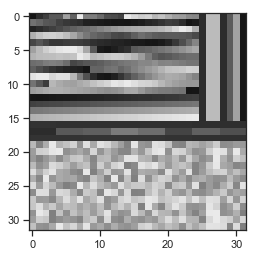

In [19]:
i = 0
aspa = real_images[i].detach().cpu().numpy()[0, 0, :, :]


plt.imshow(aspa, cmap='gray', vmin=-1.2, vmax=1.2)



n_bins = 8 # amount of bins the spectrum got scaled in
"""Image parts from the aspa, still encoded"""
spectrum = aspa[:16, :25]
mins_ = [aspa[16:17, i*4:i*4+4] for i in range(n_bins)]
stds_ = [aspa[17:18, i*4:i*4+4] for i in range(n_bins)]
maxs_ = [aspa[18:19, i*4:i*4+4] for i in range(n_bins)]

"""Decode to arrays"""
spectrum = spectrum.flatten()

mins_ = [inverse_scale(mins_[i].mean(), 0.005, 0.03) for i in range(n_bins)]
stds_ = [inverse_scale(stds_[i].mean(), 0.005, 0.03) for i in range(n_bins)]
maxs_ = [inverse_scale(maxs_[i].mean(), 1e-7, 1e-4) for i in range(n_bins)]

In [20]:
df = pd.read_csv('wavelengths_and_indices.csv', header=None, skiprows=[0], usecols=[1]) # load wavelengths
df.columns = ['x']
df = df.loc[df['x'] <= 16] # select only wavelengths <= 16
df['y'] = spectrum

df.head()

,x,y
115,15.977744,-1.000000
116,15.819548,-0.765211
117,15.662919,-0.607507
118,15.507841,-0.349719
119,15.354298,-0.355232


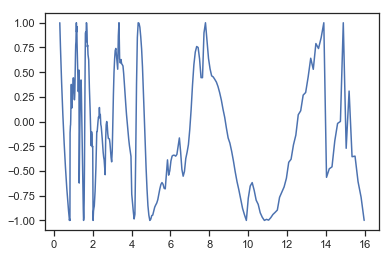

In [21]:
plt.plot(df.x, df.y)

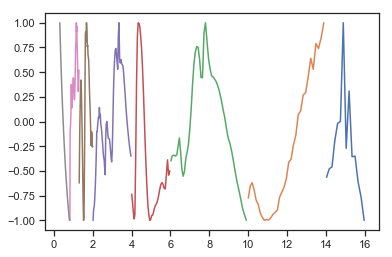

In [22]:
"""select spectrum bins"""
bin1 = df[df.x <= 0.8]
bin2 = df[(df.x > 0.8) & (df.x <= 1.3)] # select data between 2 and 4 micron
bin3 = df[(df.x > 1.3) & (df.x <= 2)]
bin4 = df[(df.x > 2) & (df.x <= 4)]
bin5 = df[(df.x > 4) & (df.x <= 6)]
bin6 = df[(df.x > 6) & (df.x <= 10)]
bin7 = df[(df.x > 10) & (df.x <= 14)]
bin8 = df[df.x > 14]

bins = [bin8, bin7, bin6, bin5, bin4, bin3, bin2, bin1]
for b in bins:
    plt.plot(b['x'], b['y'])

In [23]:
"""Inverse scale the bins"""
# min max values for spectrum from ASPA v2 notebook
min_values = [1.518400e+27, 
                  1.000000e+03, 
                  -1.842068e+01, 
                  5.592880e+07, 
                  -1.842068e+01, 
                  -1.842068e+01, 
                  -1.842068e+01]
    
max_values = [3.796000e+27, 
                  2.000000e+03, 
                  -2.302585e+00, 
                  1.048665e+08, 
                  -2.302585e+00, 
                  -2.302585e+00,
                  -2.302585e+00]

spectra_inverses = []
for i in range(7):
    bin_ = bins[i]
    max_ = maxs_[i]
    min_ = mins_[i]
    
    spectrum = bin_['y']
    spectrum_inverse = inverse_scale(spectrum, min_values[i], max_values[i])
    spectra_inverses.append(spectrum_inverse)

spectra_inverses

[115   -7.592000e+26
 116   -2.244439e+26
 117    1.347418e+26
 118    7.218801e+26
 119    7.093245e+26
 120    2.221705e+27
 121    9.026341e+26
 122    3.796000e+27
 123    1.521818e+27
 124    1.475571e+27
 125    1.071671e+27
 126    4.753513e+26
 127    4.293584e+26
 128    2.339440e+26
 Name: y, dtype: float32, 129    2000.000000
 130    1848.647461
 131    1738.863037
 132    1789.548584
 133    1528.911621
 134    1640.959717
 135    1452.853638
 136    1294.287109
 137    1267.866089
 138    1109.515381
 139    1069.145996
 140     862.858704
 141     763.521362
 142     619.129761
 143     588.042786
 144     426.376770
 145     338.820129
 146     284.695923
 147     233.666138
 148     104.840393
 149      81.349304
 150      60.190796
 151      27.592102
 152       2.956665
 153      10.636658
 154       0.000000
 155      31.335449
 156      76.975403
 157     162.579956
 158     204.680115
 159     304.922668
 160     382.673462
 161     347.728210
 162     224.983093
 

# Show results

In [24]:
real = real_images[0].detach().cpu()[0, 0, :, :]
real_masked = masked_images[0].detach().cpu()[0, 0, :, :]

#first_generated =inpainted_images[1].detach().cpu()[0, 0, :, :]
last_generated = inpainted_images[-1].detach().cpu()[0, 0, :, :]

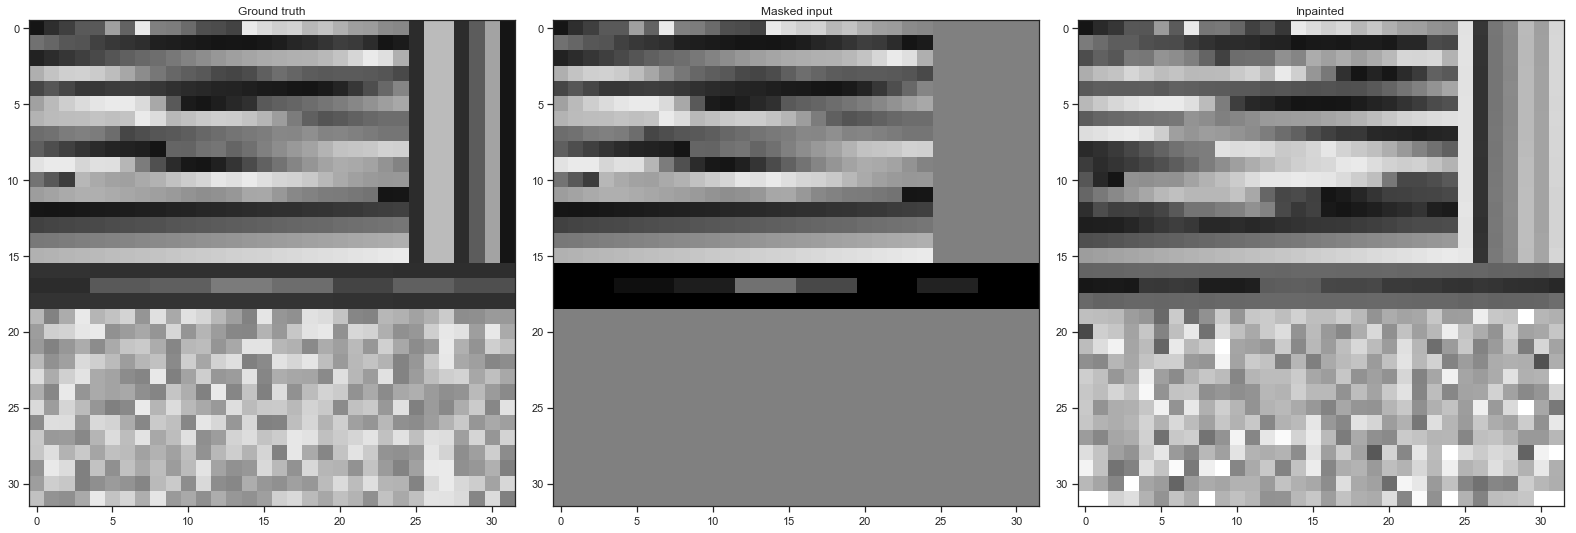

In [25]:
plt.figure(figsize=(22,10))

plt.subplot(1,3,1)
plt.imshow(real, cmap='gray', vmin=-1.2, vmax=1.2)
plt.title('Ground truth')

plt.subplot(1,3,2)
plt.imshow(real_masked, cmap='gray', vmin=-1.2, vmax=1.2)
plt.title('Masked input')

plt.subplot(1,3,3)
plt.imshow(last_generated, cmap='gray', vmin=-1.2, vmax=1.2)
plt.title('Inpainted')

plt.tight_layout()

#plt.savefig('plots/inpainting.png', dpi=1300)

mean: -0.0735 
 std: 0.5336 
 min: -1.8214 
 max: 1.7788


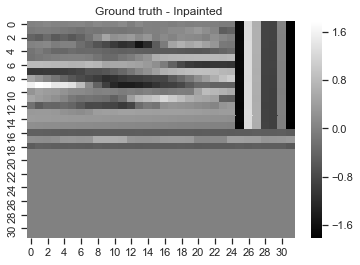

In [26]:
difference = real - last_generated
difference[19:, :] = 0 # remove the noise, it doesn't matter

#sns.heatmap(difference, cmap='gray', vmin=-2, vmax=2)
sns.heatmap(difference, cmap='gray')
plt.title('Ground truth - Inpainted ')

difference  = difference.cpu().detach().numpy().flatten()

mean, sigma, min_, max_ = difference.mean().item(), difference.std(), difference.min(), difference.max()
print('mean: %.4f \n std: %.4f \n min: %.4f \n max: %.4f' % (mean, sigma, min_, max_))

# Decoding ASPA
Need to clean this up. Using dicts like this is not clean.

In [27]:
aspa_inpainted = last_generated.numpy()
aspa_real = real.numpy()

aspa_inpainted.shape

(32, 32)

In [28]:
# Initialize ExoGAN params with zero's
inpainted_params = {
    'planet_mass': 0,
    'temp_profile': 0,
    'ch4_mixratio': 0,
    'planet_radius': 0,
    'h2o_mixratio': 0,
    'co2_mixratio': 0,
    'co_mixratio': 0
}

real_params = inpainted_params.copy()
params_errors = inpainted_params.copy()

## Inverse scale functions

In [29]:
def inverse_scale_param(X_scaled, X_min, X_max):
    return (X_scaled * (X_max-X_min)) + X_min

def inverse_scale_params(params):
    """
    Inverse scales the params array. 
    Params must be in fixed order, same order as it is encoded with.
    """
    params = params.copy()
    min_values = [1.518400e+27, 
                  1.000000e+03, 
                  -1.842068e+01, 
                  5.592880e+07, 
                  -1.842068e+01, 
                  -1.842068e+01, 
                  -1.842068e+01]
    
    max_values = [3.796000e+27, 
                  2.000000e+03, 
                  -2.302585e+00, 
                  1.048665e+08, 
                  -2.302585e+00, 
                  -2.302585e+00,
                  -2.302585e+00]

    params_inverse_scaled = []
    for i in range(len(params)):
        param = params[i]
        min_= min_values[i]
        max_ = max_values[i]

        params_inverse_scaled.append(inverse_scale_param(param, min_, max_))
    
    return params_inverse_scaled

## Inpainted params

In [30]:
inpainted_params_values = [aspa_inpainted[:16, 25+i:26+i] for i in range(len(inpainted_params))]
inpainted_params_mean  = [i.mean() for i in inpainted_params_values]

inpainted_params_mean

[0.9374328,
 -0.7216464,
 -0.08394126,
 0.0979972,
 0.5613882,
 0.32874948,
 0.80603105]

In [31]:
y = (0.5876265 * (-2.306--1.842068e+01))+-1.842068e+01
y

-8.95126699298

In [32]:
inpainted_params_mean = inverse_scale_params(inpainted_params_mean)
inpainted_params_mean

[3.653497003507614e+27,
 278.35357189178467,
 -19.773653178762757,
 60724557.74421841,
 -9.372171748187245,
 -13.121864684598744,
 -5.428994990585149]

### Convert mixtures from log back to regular scale

In [33]:
for i,param in enumerate(inpainted_params):
    if 'mixratio' in param:
        inpainted_params[param] = (inpainted_params_mean[i]) # convert log back to regular scale
    else:
        inpainted_params[param] = inpainted_params_mean[i]

In [34]:
inpainted_params

{'planet_mass': 3.653497003507614e+27,
 'temp_profile': 278.35357189178467,
 'ch4_mixratio': -19.773653178762757,
 'planet_radius': 60724557.74421841,
 'h2o_mixratio': -9.372171748187245,
 'co2_mixratio': -13.121864684598744,
 'co_mixratio': -5.428994990585149}

## Real params
Ground truth params

In [35]:
real_params_values = [aspa_real[:16, 25+i:26+i] for i in range(len(real_params))]
real_params_mean  = [i.mean() for i in real_params_values]
real_params_mean

[-0.7777778,
 0.5555556,
 0.5555555,
 -0.7777778,
 -0.3333334,
 0.33333328,
 -1.0000001]

In [36]:
real_params_mean = inverse_scale_params(real_params_mean)
real_params_mean

[-2.530666968345642e+26,
 1555.5555820465088,
 -9.466183311507404,
 17866143.796241283,
 -23.79337945416555,
 -13.047982467261107,
 -34.53877692142666]

### Convert mixtures from log back to regular scale

In [37]:
for i,param in enumerate(real_params):
    if 'mixratio' in param:
        real_params[param] = (real_params_mean[i]) # convert log back to regular scale
    else:
        real_params[param] = real_params_mean[i]

In [38]:
real_params

{'planet_mass': -2.530666968345642e+26,
 'temp_profile': 1555.5555820465088,
 'ch4_mixratio': -9.466183311507404,
 'planet_radius': 17866143.796241283,
 'h2o_mixratio': -23.79337945416555,
 'co2_mixratio': -13.047982467261107,
 'co_mixratio': -34.53877692142666}

## Percentage error

% error = $\frac{y-\hat{y}}{\hat{y}} \cdot$ 100

In [39]:
percentage_errors = []
for param in real_params:
    y_hat = real_params[param]
    y = inpainted_params[param]
    
    params_errors[param] = ((y - y_hat) / y_hat)*100

params_errors

{'planet_mass': -1543.6893709076203,
 'temp_profile': -82.1058421116924,
 'ch4_mixratio': 108.887283586884,
 'planet_radius': 239.88620284693872,
 'h2o_mixratio': -60.61016987418135,
 'co2_mixratio': 0.5662347993110506,
 'co_mixratio': -84.28144979500652}

## Print results

In [40]:
for param in inpainted_params:
    real = real_params[param]
    inpainted = inpainted_params[param]
    error = params_errors[param]
    
    print('%s \t Real value: %.5e \t inpainted value: %.5e \t perc. diff.: %.25f' % (param, real, inpainted, error))

planet_mass 	 Real value: -2.53067e+26 	 inpainted value: 3.65350e+27 	 perc. diff.: -1543.6893709076202867436222732
temp_profile 	 Real value: 1.55556e+03 	 inpainted value: 2.78354e+02 	 perc. diff.: -82.1058421116923966565082083
ch4_mixratio 	 Real value: -9.46618e+00 	 inpainted value: -1.97737e+01 	 perc. diff.: 108.8872835868839956674491987
planet_radius 	 Real value: 1.78661e+07 	 inpainted value: 6.07246e+07 	 perc. diff.: 239.8862028469387155382719357
h2o_mixratio 	 Real value: -2.37934e+01 	 inpainted value: -9.37217e+00 	 perc. diff.: -60.6101698741813521564836265
co2_mixratio 	 Real value: -1.30480e+01 	 inpainted value: -1.31219e+01 	 perc. diff.: 0.5662347993110505850467007
co_mixratio 	 Real value: -3.45388e+01 	 inpainted value: -5.42899e+00 	 perc. diff.: -84.2814497950065231179905823


# Functionize this to output the MAPE of all inpainted images per metric 

In [41]:
#real_images = []
#final_inpainted_images = []

reals = []
inpainteds = []
errors = []
for i in range(len(real_images)-1):
    aspa_real = real_images[i].detach().cpu()[0, 0, :, :].numpy() # size is 32,32 now
    aspa_inpainted = final_inpainted_images[i].detach().cpu()[0, 0, :, :].numpy() # size is 32,32 now

    """Decode inpainted aspa"""
    inpainted_params_values = [aspa_inpainted[:16, 25+j:26+j] for j in range(len(inpainted_params))]
    inpainted_params_mean  = [k.mean() for k in inpainted_params_values]
    inpainted_params_mean = inverse_scale_params(inpainted_params_mean)
    
    for a,param in enumerate(inpainted_params):
        if 'mixratio' in param:
            inpainted_params[param] = inpainted_params_mean[a] # convert log back to regular scale
        else:
            inpainted_params[param] = inpainted_params_mean[a]
    
    """Decode real aspa"""
    real_params_values = [aspa_real[:16, 25+b:26+b] for b in range(len(real_params))]
    real_params_mean  = [c.mean() for c in real_params_values]
    real_params_mean = inverse_scale_params(real_params_mean)
    
    for d,param in enumerate(real_params):
        if 'mixratio' in param:
            real_params[param] = real_params_mean[d] # convert log back to regular scale
        else:
            real_params[param] = real_params_mean[d]

    """Calculate percentage difference"""
    params_errors = dict.fromkeys(params_errors, 0) # copy dicts' keys, set all values to zero
    for param in real_params:
        y_hat = real_params[param]
        y = inpainted_params[param]
        
        params_errors[param] = ((y - y_hat) / y_hat)*100

    reals.append(real_params.copy()) # !!!!! for some reason dicts need to be copied, to be able to append to a list... otherwise the dicts inside the lists get update too
    inpainteds.append(inpainted_params.copy())
    errors.append(params_errors.copy())


/opt/jupyterhub/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in double_scalars


# Create one large df from all the dicts

In [42]:
dfs = []
for i in range(len(errors)):
    print(reals[i])
    df1 = pd.DataFrame(errors[i], index=[0])
    df1.columns = [i+'_error' for i in df1.columns]

    df2 = pd.DataFrame(reals[i], index=[0])
    df2.columns = [i+'_real' for i in df2.columns]

    df3 = pd.DataFrame(inpainteds[i], index=[0])
    df3.columns = [i+'_inpainted' for i in df3.columns]

    df = pd.concat([df1, df2, df3], axis=1)
    
    dfs.append(df)

df = pd.concat(dfs)

{'planet_mass': -2.530666968345642e+26, 'temp_profile': 1555.5555820465088, 'ch4_mixratio': -9.466183311507404, 'planet_radius': 17866143.796241283, 'h2o_mixratio': -23.79337945416555, 'co2_mixratio': -13.047982467261107, 'co_mixratio': -34.53877692142666}
{'planet_mass': 1.7714666685521603e+27, 'temp_profile': 444.4444179534912, 'ch4_mixratio': -16.62978126274731, 'planet_radius': 61366322.26273492, 'h2o_mixratio': -2.3025850000000005, 'co2_mixratio': -2.3025850000000005, 'co_mixratio': -16.62978126274731}
{'planet_mass': 3.289866696834564e+27, 'temp_profile': 222.2222089767456, 'ch4_mixratio': -16.62978126274731, 'planet_radius': 50491277.73726508, 'h2o_mixratio': -20.211580298411846, 'co2_mixratio': -27.375178609919253, 'co_mixratio': -2.3025850000000005}
{'planet_mass': 1.7714666685521603e+27, 'temp_profile': 444.4444179534912, 'ch4_mixratio': -13.047982467261107, 'planet_radius': 72241367.15281904, 'h2o_mixratio': -23.79337945416555, 'co2_mixratio': -9.466183311507404, 'co_mixrati

# Errors of all images

In [43]:
df.describe()

,planet_mass_error,temp_profile_error,ch4_mixratio_error,planet_radius_error,h2o_mixratio_error,co2_mixratio_error,co_mixratio_error,planet_mass_real,temp_profile_real,ch4_mixratio_real,...,h2o_mixratio_real,co2_mixratio_real,co_mixratio_real,planet_mass_inpainted,temp_profile_inpainted,ch4_mixratio_inpainted,planet_radius_inpainted,h2o_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,2.400000e+01,24.000000,24.000000,...,24.000000,24.000000,24.000000,2.400000e+01,24.000000,24.000000,2.400000e+01,24.000000,24.000000,24.000000
mean,-66.276992,inf,-5.414019,-1.858322,-2.369559,1.610515,6.954456,1.666022e+27,898.148140,-19.017647,...,-17.823714,-16.480540,-18.719164,1.450991e+27,961.403351,-17.696876,4.530536e+07,-17.100954,-16.758729,-16.673370
std,203.219452,NaN,9.599960,10.501702,12.453167,16.172663,59.276054,1.708115e+27,716.283033,10.167497,...,10.222211,10.428172,12.626813,1.572953e+27,762.177735,9.049931,2.258385e+07,9.518924,10.987567,11.859780
min,-928.590414,-131.136077,-39.745919,-27.988045,-31.003919,-62.802967,-93.173579,-7.592000e+26,0.000000,-34.538777,...,-34.538777,-34.538777,-34.538777,-1.588477e+27,-138.382554,-33.685362,1.286576e+07,-31.625527,-35.576953,-34.344929
25%,-71.735514,-51.218297,-6.654854,-5.898524,-4.410815,0.961345,-16.584109,-2.530667e+26,388.888866,-30.956977,...,-24.688829,-27.375179,-30.956977,-6.253624e+24,343.611240,-26.049306,2.436618e+07,-24.708279,-27.658465,-26.522283
50%,-16.798464,5.765874,-2.514215,1.249900,-0.945640,3.117060,-6.247107,1.771467e+27,555.555537,-16.629781,...,-20.211580,-13.047982,-18.420681,1.509967e+27,812.467203,-16.287312,5.099841e+07,-18.274162,-13.595439,-15.317805
75%,19.458629,138.602064,-0.858818,4.213651,2.626339,6.622671,26.324841,3.289867e+27,1611.111134,-13.047982,...,-9.466183,-8.570734,-4.988935,2.779387e+27,1727.426484,-11.531767,6.170433e+07,-9.290401,-6.358417,-5.568721
max,109.230423,inf,4.890942,16.409592,32.917340,36.829072,151.344252,3.796000e+27,2000.000000,-5.884385,...,-2.302585,-2.302585,-2.302585,4.204318e+27,2297.845960,-5.634175,8.407282e+07,-2.173112,-2.528210,-1.379728


In [44]:
df.describe()

,planet_mass_error,temp_profile_error,ch4_mixratio_error,planet_radius_error,h2o_mixratio_error,co2_mixratio_error,co_mixratio_error,planet_mass_real,temp_profile_real,ch4_mixratio_real,...,h2o_mixratio_real,co2_mixratio_real,co_mixratio_real,planet_mass_inpainted,temp_profile_inpainted,ch4_mixratio_inpainted,planet_radius_inpainted,h2o_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,2.400000e+01,24.000000,24.000000,...,24.000000,24.000000,24.000000,2.400000e+01,24.000000,24.000000,2.400000e+01,24.000000,24.000000,24.000000
mean,-66.276992,inf,-5.414019,-1.858322,-2.369559,1.610515,6.954456,1.666022e+27,898.148140,-19.017647,...,-17.823714,-16.480540,-18.719164,1.450991e+27,961.403351,-17.696876,4.530536e+07,-17.100954,-16.758729,-16.673370
std,203.219452,NaN,9.599960,10.501702,12.453167,16.172663,59.276054,1.708115e+27,716.283033,10.167497,...,10.222211,10.428172,12.626813,1.572953e+27,762.177735,9.049931,2.258385e+07,9.518924,10.987567,11.859780
min,-928.590414,-131.136077,-39.745919,-27.988045,-31.003919,-62.802967,-93.173579,-7.592000e+26,0.000000,-34.538777,...,-34.538777,-34.538777,-34.538777,-1.588477e+27,-138.382554,-33.685362,1.286576e+07,-31.625527,-35.576953,-34.344929
25%,-71.735514,-51.218297,-6.654854,-5.898524,-4.410815,0.961345,-16.584109,-2.530667e+26,388.888866,-30.956977,...,-24.688829,-27.375179,-30.956977,-6.253624e+24,343.611240,-26.049306,2.436618e+07,-24.708279,-27.658465,-26.522283
50%,-16.798464,5.765874,-2.514215,1.249900,-0.945640,3.117060,-6.247107,1.771467e+27,555.555537,-16.629781,...,-20.211580,-13.047982,-18.420681,1.509967e+27,812.467203,-16.287312,5.099841e+07,-18.274162,-13.595439,-15.317805
75%,19.458629,138.602064,-0.858818,4.213651,2.626339,6.622671,26.324841,3.289867e+27,1611.111134,-13.047982,...,-9.466183,-8.570734,-4.988935,2.779387e+27,1727.426484,-11.531767,6.170433e+07,-9.290401,-6.358417,-5.568721
max,109.230423,inf,4.890942,16.409592,32.917340,36.829072,151.344252,3.796000e+27,2000.000000,-5.884385,...,-2.302585,-2.302585,-2.302585,4.204318e+27,2297.845960,-5.634175,8.407282e+07,-2.173112,-2.528210,-1.379728


In [45]:
params = [param for param in real_params.keys()]
param = params[2]
print(param)

ch4_mixratio


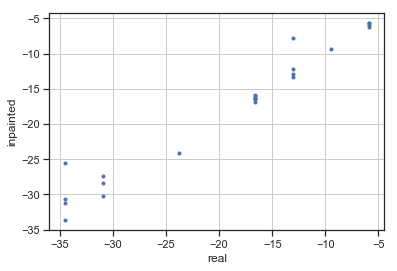

In [46]:
x = df[param+'_real']
y = df[param+'_inpainted']

plt.plot(x, y, '.')
plt.xlabel('real')
plt.ylabel('inpainted')
plt.grid()

In [47]:
x

0    -9.466183
0   -16.629781
0   -16.629781
0   -13.047982
0   -16.629781
0   -34.538777
0   -13.047982
0    -5.884385
0   -16.629781
0   -34.538777
0    -5.884385
0   -30.956977
0   -13.047982
0   -34.538777
0   -30.956977
0   -30.956977
0   -34.538777
0   -16.629781
0   -13.047982
0   -16.629781
0   -23.793379
0   -16.629781
0    -5.884385
0    -5.884385
Name: ch4_mixratio_real, dtype: float64

In [48]:
y

0    -9.367731
0   -16.086125
0   -16.242807
0    -7.861942
0   -16.408122
0   -25.596096
0   -13.398663
0    -6.172186
0   -16.331817
0   -31.172416
0    -5.634175
0   -30.165240
0   -12.927395
0   -30.676780
0   -28.374012
0   -27.408937
0   -33.685362
0   -16.857787
0   -12.253113
0   -15.918684
0   -24.050206
0   -16.519572
0    -5.716134
0    -5.899732
Name: ch4_mixratio_inpainted, dtype: float64

(array([ 1.,  0.,  0.,  1.,  0.,  0.,  3.,  4., 11.,  4.]),
 array([-39.74591898, -35.28223286, -30.81854674, -26.35486063,
        -21.89117451, -17.42748839, -12.96380227,  -8.50011615,
         -4.03643003,   0.42725609,   4.89094221]),
 <a list of 10 Patch objects>)

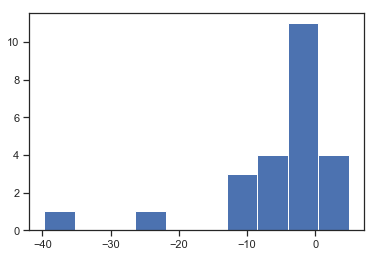

In [49]:
plt.hist(df[param+'_error'])

ValueError: supplied range of [-131.13607651806333, inf] is not finite

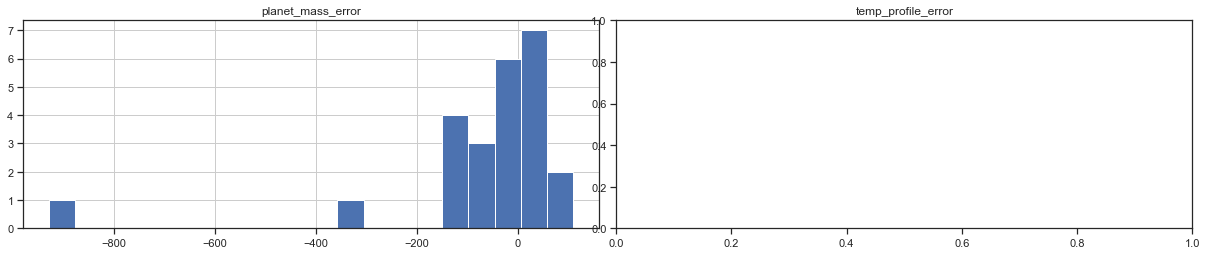

In [50]:
plt.figure(figsize=((25,10)))
for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.title(param+'_error')
    plt.hist(df[param+'_error'], bins=20)
    plt.grid()
    plt.tight_layout()

plt.savefig('plots//Validation error hist of '+str(len(images))+' images.png', dpi=1200)
print('saved')

In [ ]:
df.to_csv('Validation error of '+str(len(images))+' images')

In [ ]:
df.head()

In [ ]:
print('DONE')

In [ ]:
param = params[2]
df[[param+'_real', param+'_inpainted']]

In [ ]:
print('Done')

In [ ]:
print('Done')

In [ ]:
print('done')

In [ ]:
its = np.array(n_iteration)
plt.hist(its)
plt.grid()

its.mean(), its.std()